# CM1 Belegarbeit

### `MR1?`

four-character identifier of structure: *M*ixing*R*atio[*mixing ratio in g/kg*], e.g., MR11

- stationary domain, `imove` = 0
- dimensions: 240km x 180km x 20km, 480x360x80 grid 
- `dx`, `dy` = 500m, `dz` = 250m
- simulation duration `timmax` = 3h, time step `dtl` = 1.5s, output frequency `tapfrq` = 5min
- base-state sounding `isnd` = 5 (Weisman-Klemp supercell):
``` 
!  variables related to Weisman-Klemp analytic sounding
z_trop   = 12000.0               ! height of tropopause (m)
th_trop  = 343.0                 ! theta at tropopause (K)
t_trop   = 213.0                 ! temp at tropopause (K)
th_sfc   = 300.0                 ! theta at surface (K)
prs_sfc  = 100000.0              ! pressure at surface (Pa)
qv_pbl   = [0.011, 0.014, 0.016] ! constant value of mixing ratio in PBL
```
 
- `iinit` = 1 (warm bubble)
  - bubble center at (x,y) = (50,50)km, `bubble_x` = -70km, `bubble_y` = -40km
```
zc      =   1500.0  ! height of center of bubble above ground (m)
bhrad   =  10000.0  ! horizontal radius of bubble (m)
bvrad   =   1500.0  ! vertical radius of bubble (m)
bptpert =      2.0  ! max potential temp perturbation (K)
```
- microphysics `ptype` = 5 (two-moment Morrison scheme, necessary for reflectivity output)
- large ice category `ihail` = 1 (hail)
- turbulence `cm1setup` = 1 (large-eddy simulation)
- subgrid-scale turbulence model `sgsmodel` = 1 (TKE scheme)
- no planetary boundary layer `ipbl` = 0
- wind profile `iwnd` = 2 (idealized "quarter-circle" Weisman&Rotunno hodograph)
  - `udep1` = 2000m, `udep2` = 6000m, `umax1` = 7m/s, `umax2` = 31m/s
- additional output variables:
```
output_sgs - maximum graupel/hail mixing ratio at lowest model level
output_dbz - reflectivity (dBZ)?  Only available for ptype=2,3,5
             (Goddard-LFO, Thompson, Morrison schemes, respectively)
             also outputs composite reflectivity (cref)
             (i.e., max reflectivity in the column)
output_buoyancy - buoyancy (relative to model's base state)?
output_cape -  convective available potential energy (CAPE)?
output_cin - convective inhibition (CIN)?
output_lcl - lifted condensation level (LCL)?
output_lfc - level of free convection (LFC)?

output_th       - potential temperature?
output_thpert   - potential temperature perturbation?
output_prs      - pressure?
output_prspert  - pressure perturbation?
output_qv       - water vapor mixing ratio?
output_qvpert   - perturbation water vapor mixing ratio?
output_q        - liquid and solid water mixing ratios?
                  (and number concentrations for double-moment schemes)
```
- curta:
  - `ppnode` = 16

In [1]:
# DO NOT FORGET TO ACTIVATE "CM1" CONDA ENV

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, colormaps, colors
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd
from netCDF4 import Dataset
# alternatively, use 
import xarray as xr
# create skew-t/ln-p diagrams
from metpy.plots import SkewT, Hodograph, ctables
from metpy.units import units
import metpy.calc as mpcalc

# figure beautification
sns.set_theme(
    style='whitegrid',
    palette='deep',
    color_codes=True # access seaborn colors by changing matplotlib color shorthands
)
#plt.rcParams["xtick.direction"] = "in"
#plt.rcParams["ytick.direction"] = "in"
%config InlineBackend.figure_format = 'retina'

## Find realistic range of mixing ratio

### Import list of tornadoes from ESWD

In [2]:
df = pd.read_csv(
    "../data/tornado-list.csv",
    usecols=["event", "lat_n", "lon_e", "date", "time_utc"],
)

df["datetime"] = pd.to_datetime(df["date"] + df["time_utc"],
                                format="%d-%m-%Y%H:%M:%S")

df.head()

# note: both era5 and tornado times are in UTC

,event,lat_n,lon_e,date,time_utc,datetime
0,tornado,52.82,13.65,29-11-2015,21:57:00,2015-11-29 21:57:00
1,tornado,51.08,10.82,17-10-2015,14:30:00,2015-10-17 14:30:00
2,tornado,54.08,12.27,26-09-2015,08:43:00,2015-09-26 08:43:00
3,tornado,51.65,6.38,22-09-2015,15:15:00,2015-09-22 15:15:00
4,tornado,54.31,10.90,15-09-2015,14:40:00,2015-09-15 14:40:00


### Import ERA5 data

In [3]:
# get data from freva
era = xr.open_dataset("/daten/reana/arch/reanalysis/reanalysis/ECMWF/IFS/ERAINT/6hr/atmos/hus/r1i1p1/hus_6hrPlev_reanalysis_ERAINT_r1i1p1_2015010100-2015123118.nc")

# get data-array from data-set
hus = era['hus']

Convert specific humidity $q$ to mixing ratio $w$ as follows,

$$ w = \frac{q}{1-q}.$$

### Visualize mixing ratio at tornado sites

In [4]:
# shape: (n_tornado, n_plev)
mr_tornado = np.zeros((len(df), len(hus['plev'])))

# loop over all tornados
for i in range(len(df)):
    # get specific humidity from tornado site (df)
    hus_tornado = hus.sel(lat=df['lat_n'][i], lon=df['lon_e'][i], 
                          time=df['datetime'][i],
                          method='nearest')
    # convert to mixing ratio & save data
    mr_tornado[i, :] = hus_tornado / (1 - hus_tornado)

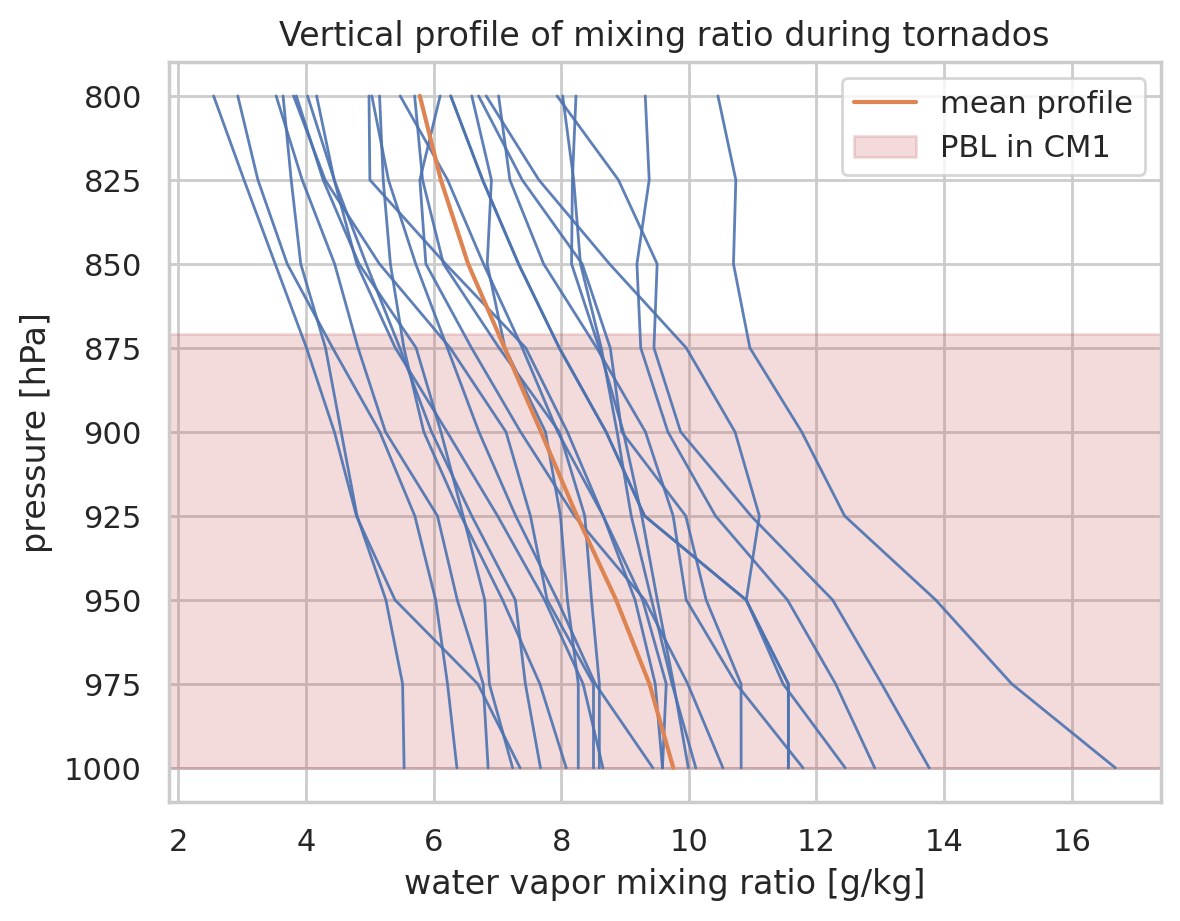

In [5]:
# plot vertical profile of mixing ratio
# with highlighted planetary boundary layer
# (apparently, mixing ratio is only computed 
#  in era5 data up to 800hPa)

# although, short matplotlib color codes are adjusted, I would
# still like to pick colors from seaborn color palette manually
snsorange = sns.color_palette()[1]

fig, ax = plt.subplots()

for i in range(len(df)):
    # unit conversion
    ax.plot(mr_tornado[i, :] * 1e3, hus['plev'] / 100,
            lw=1, c="b", alpha=0.9)

# compute & plot mean profile
mean_profile = np.mean(mr_tornado, axis=0)
ax.plot(mean_profile * 1e3, hus['plev'] / 100,
        lw=1.5, c=snsorange, label="mean profile")
# highlight mean planetary boundary layer of cm1 
ax.axhspan(1e3, 870.89, color="r", alpha=0.2, label="PBL in CM1")

# plot beautification
ax.legend()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel("pressure [hPa]")
ax.set_xlabel("water vapor mixing ratio [g/kg]")
ax.set_title("Vertical profile of mixing ratio during tornados")
fig.savefig("../figs/mr-profile.png", dpi=300, bbox_inches="tight")

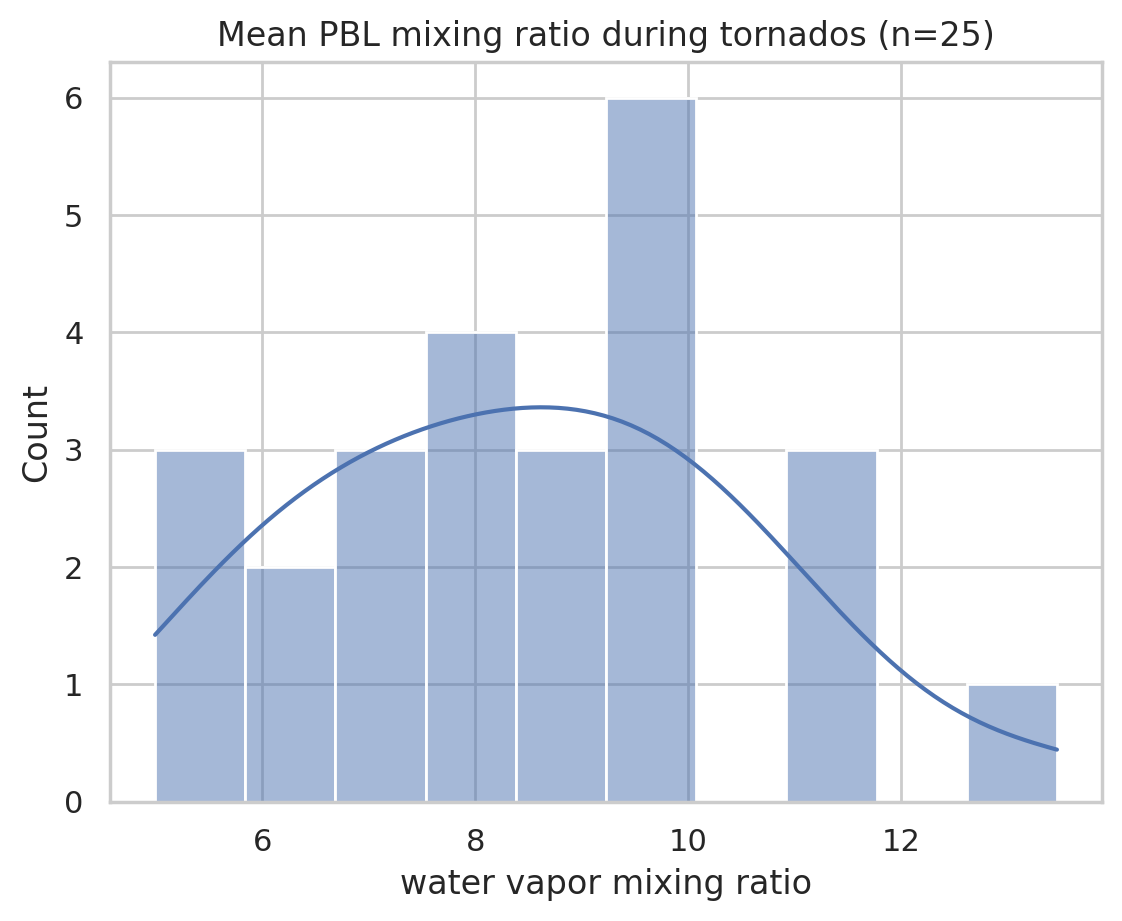

In [6]:
# select mixing ratio values only in planetary boundary layer (pbl)
# height derived from cm1 simulation output (see below)

# get number of pressure levels in pbl
nplev = len(hus.sel(plev=slice(1000e2, 870.89e2))['plev'])
# compute mean mixing ratio per tornado
mr_pbl_mean = np.mean(mr_tornado[:,:nplev], axis=1)

ax = sns.histplot(data=mr_pbl_mean * 1e3, kde=True, bins=10)
ax.set_xlabel("water vapor mixing ratio")
ax.set_title("Mean PBL mixing ratio during tornados (n=25)")
plt.savefig("../figs/mr-distribution.png", dpi=300, bbox_inches="tight")

## Sounding & Hodograph

### Import data

In [7]:
sims = ["mr11", "mr14", "mr16", "mr21"]

prs = {} # pressure [Pa]
th = {}  # potential temperature [K]
qv = {}  # water vapor mixing ratio [kg/kg]
u = {}   # horizontal wind components
v = {}
agl = {} # height on model levels

# masked arrays and pint units framework have compatibility issues:
# https://stackoverflow.com/questions/61895233/is-there-an-issue-with-the-metpy-units-function

for mr in sims:
    f = Dataset(f"../data/skewt-{mr}.nc")
    prs[mr] = units.hPa / 100 * f.variables["prs"][0,:,0,0]
    th[mr]  = units.K * f.variables["th"][0,:,0,0]
    qv[mr]  = units.g / units.kg * 1000 * f.variables["qv"][0,:,0,0]
    u[mr]   = units.m / units.s * f.variables["u"][0,:,0,0]
    v[mr]   = units.m / units.s * f.variables["v"][0,:,0,0]
    agl[mr] = units.km * f.variables["zh"][:]
    f.close()

### Height of PBL in CM1

In [8]:
# find maximum height of constant mixing ratio
def constqv(simlabel, mr):
    for i in range(len(qv[simlabel])):
        # first time mixing ratio is lowered
        if qv[simlabel][i] < mr:
            # print previous pressure level, where mixing ratio
            # was still constant
            print(f"\t{simlabel}:", prs[simlabel][i-1])
            return prs[simlabel][i-1]

print("last pressure level with initial mixing ratio:\n")

prsl = []
for s, mr in zip(sims, [11, 14, 16] * units.g / units.kg):
    # doesn't work with units
    prsl.append(constqv(s, mr).magnitude)

print("\nmean of above pressure levels:\n")
print(f"\t{np.mean(prsl)} hPa")

last pressure level with initial mixing ratio:

	mr11: 828.7420654296875 hectopascal
	mr14: 878.9880981445312 hectopascal
	mr16: 904.947021484375 hectopascal

mean of above pressure levels:

	870.8923950195312 hPa


### Compute dewpoint & temperature

In [9]:
t = {}    # temperature
vprs = {} # water vapor (partial) pressure
td = {}   # dewpoint temperature

for mratio in sims:
    t[mratio] = mpcalc.temperature_from_potential_temperature(
        pressure=prs[mratio],
        potential_temperature=th[mratio]
    )
    vprs[mratio] = mpcalc.vapor_pressure(
        pressure=prs[mratio],
        mixing_ratio=qv[mratio]
    )
    td[mratio] = mpcalc.dewpoint(
        vapor_pressure=vprs[mratio]
    )

### Highest possible mixing ratio

In [10]:
# calculate mixing ratio from relative humidity, temperature, and pressure at lowest model level
# for 100% relative humidity -> instant moist-adiabatic convection
max_mr = mpcalc.mixing_ratio_from_relative_humidity(prs['mr11'][0], t['mr11'][0], 1.).to('g/kg')

print("maximum mixing ratio:\n")
print(f"\t{max_mr}")

maximum mixing ratio:

	21.664207313961555 gram / kilogram


### Thermodynamic calculations

In [11]:
lcl_pressure = {}
lcl_temperature = {}
parcel_prof = {}
sbcape = {}
sbcin = {}

for mr in sims:
    # calculate the lifted condensation level LCL
    lcl_pressure[mr], lcl_temperature[mr] = mpcalc.lcl(prs[mr][0], t[mr][0], td[mr][0])
    # calculate the parcel profile
    parcel_prof[mr] = mpcalc.parcel_profile(prs[mr], t[mr][0], td[mr][0])#.to('degC')
    # compute surface-based CAPE
    sbcape[mr], sbcin[mr] = mpcalc.surface_based_cape_cin(prs[mr], t[mr], td[mr])

### Plot sounding

- CAPE: convective available potential energy
- CIN: convective inhibition (can be thought of as "negative CAPE")
- LCL: lifted condensation level (cloud base)
- LFC: level of *free* convection

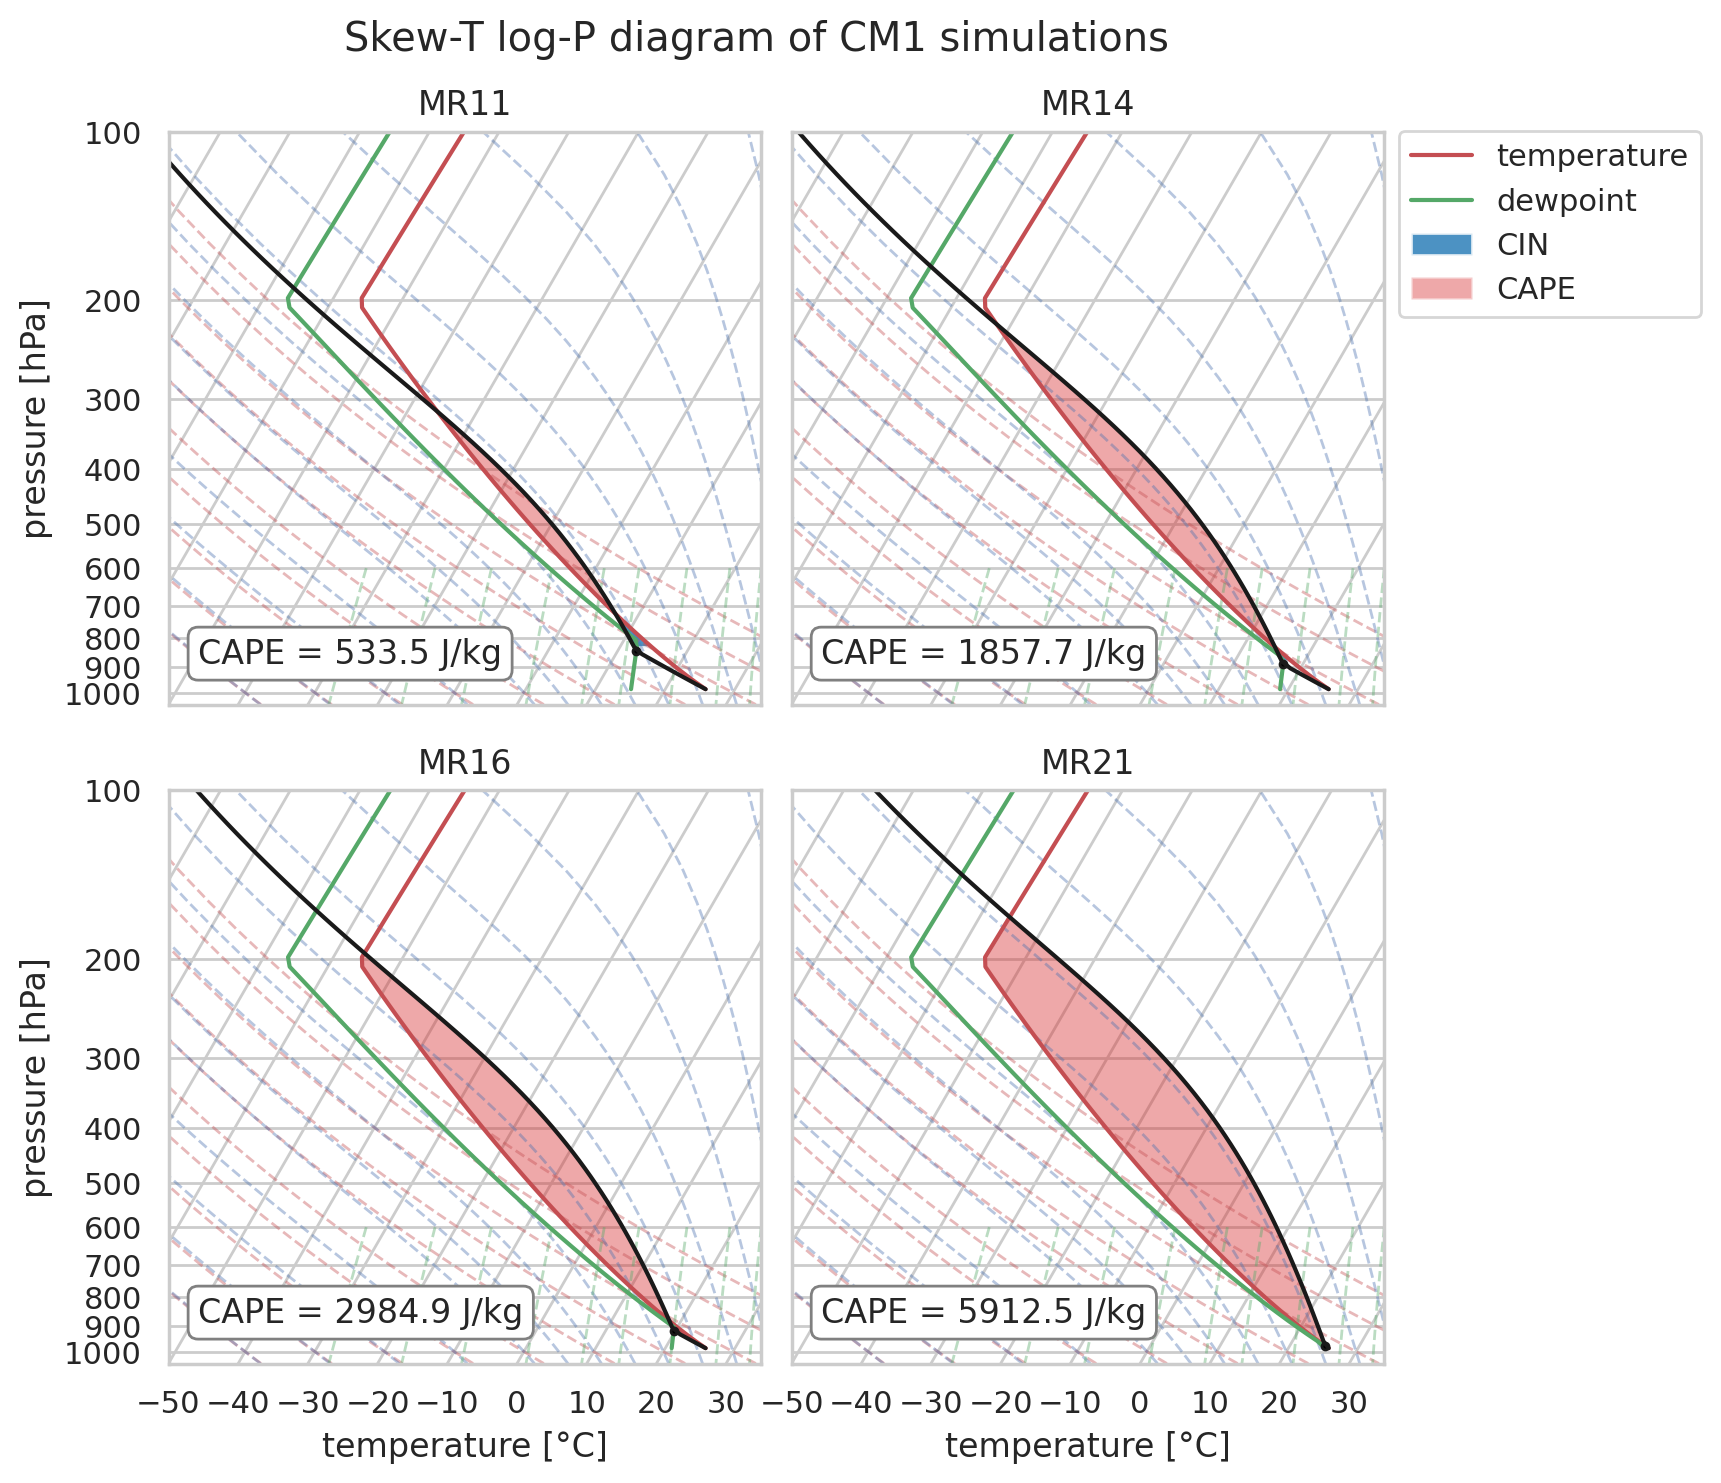

In [12]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 2, wspace=.01, hspace=.15)

for i, mr in enumerate(sims):
    skew = SkewT(fig=fig, subplot=gs[i])
    
    # plot data
    skew.plot(prs[mr], t[mr], 'r',
              label="temperature" if i == 0 else "")
    skew.plot(prs[mr], td[mr], 'g',
              label="dewpoint" if i == 0 else "")
    #skew.plot_barbs(prs[mratio], u[mratio], v[mratio])
    
    # plot LCL as black dot
    skew.plot(lcl_pressure[mr], lcl_temperature[mr],
              'ko', markerfacecolor='black', markersize=2.5)
    # plot the parcel profile as a black line
    skew.plot(prs[mr], parcel_prof[mr], 'k')

    # shade areas of CAPE and CIN
    skew.shade_cin(prs[mr], t[mr], parcel_prof[mr], td[mr],
                   label="CIN" if i == 0 else "", alpha=0.8)
    skew.shade_cape(prs[mr], t[mr], parcel_prof[mr],
                    label="CAPE" if i == 0 else "")

    # add the relevant special lines
    skew.plot_dry_adiabats(lw=1, alpha=0.4)
    skew.plot_moist_adiabats(lw=1, alpha=0.4)
    skew.plot_mixing_lines(lw=1, alpha=0.4)

    # add CAPE value
    props = dict(boxstyle='round', fc='white', ec="grey", lw=1)
    skew.ax.text(0.05, 0.06, f'CAPE = {sbcape[mr]:.1f~P}',
                 transform=skew.ax.transAxes, verticalalignment="bottom",
                 bbox=props)

    # beautification
    skew.ax.set_title(mr.upper())
    skew.ax.set_xlabel('temperature [°C]')
    skew.ax.set_ylabel('pressure [hPa]')
    skew.ax.set_xlim(-50, 35)

    # workaround to shared x- and y-axes
    if i in (0, 1):
        skew.ax.set_xticklabels([])
        skew.ax.set_xlabel(None)
    if i in (1, 3):
        skew.ax.set_yticklabels([])
        skew.ax.set_ylabel(None)
    

fig.legend(bbox_to_anchor=(1.1, 0.89))
fig.suptitle("Skew-T log-P diagram of CM1 simulations", y=.95)
fig.savefig("../figs/sounding.png", dpi=300, bbox_inches="tight")

### Plot hodograph

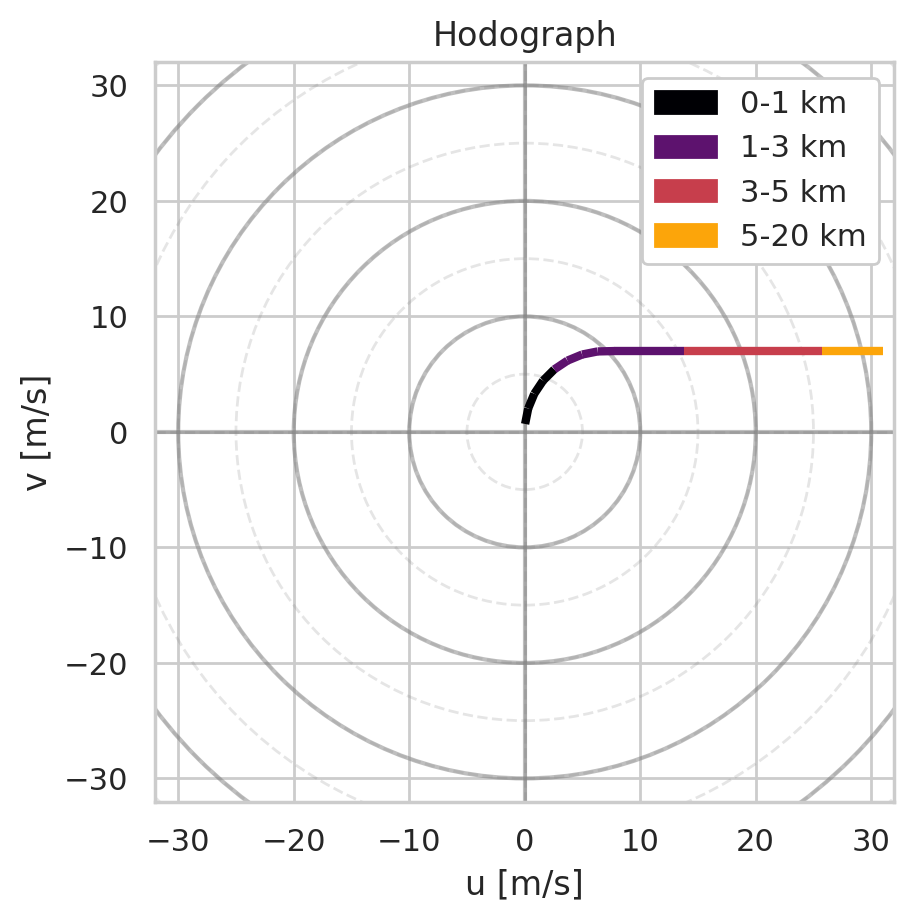

In [13]:
fig, ax = plt.subplots()
h = Hodograph(ax=ax, component_range=32)
h.add_grid(increment=10, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=5, ls='--', lw=1, alpha=0.2)

# height intervals:
intervals = [0, 1, 3, 5, 20] # constant wind from 6km AGL
# colormap:
cmap = colormaps["inferno"]
# get colors (one less than intervals)
cmap_colors = [cmap(i) for i in np.linspace(0.0,0.8,len(intervals)-1)]

# plot the line colored by height AGL
line = h.plot_colormapped(u['mr11'], v['mr11'], agl['mr11'],
                          colors=cmap_colors, intervals=intervals) 

# add legend to hodograph
patches = []
for i in range(len(intervals)-1):
    c = cmap_colors[i]
    p = Patch(color=c,
              label=f"{intervals[i]}-{intervals[i+1]} km")
    patches.append(p)

ax.legend(handles=patches, loc=1, framealpha=1)

ax.set_xlabel("u [m/s]")
ax.set_ylabel("v [m/s]")
ax.set_title("Hodograph")
fig.savefig("../figs/hodograph.png", dpi=300, bbox_inches="tight")

## Reflectivity

In [14]:
# import reflectivity data

#dbz = xr.open_dataset("/daten/model-course/WS2023/rw0064fu/cm1/MR16/cm1out.nc")['dbz']
#maxdbz = dbz.max(dim=['zh', 'time'])
#plt.pcolormesh(maxdbz)

In [15]:
# better:
# cref = composite reflectivity (i.e., maximum reflectivity in column)

cref = {}
maxdbz = {} # time-integrated maximum composite reflectivity
# import data
for mr in sims:
    cref[mr] = xr.open_dataset(f"/daten/model-course/WS2023/rw0064fu/cm1/{mr.upper()}/cm1out.nc")['cref']
    maxdbz[mr] = cref[mr].max(dim='time') 

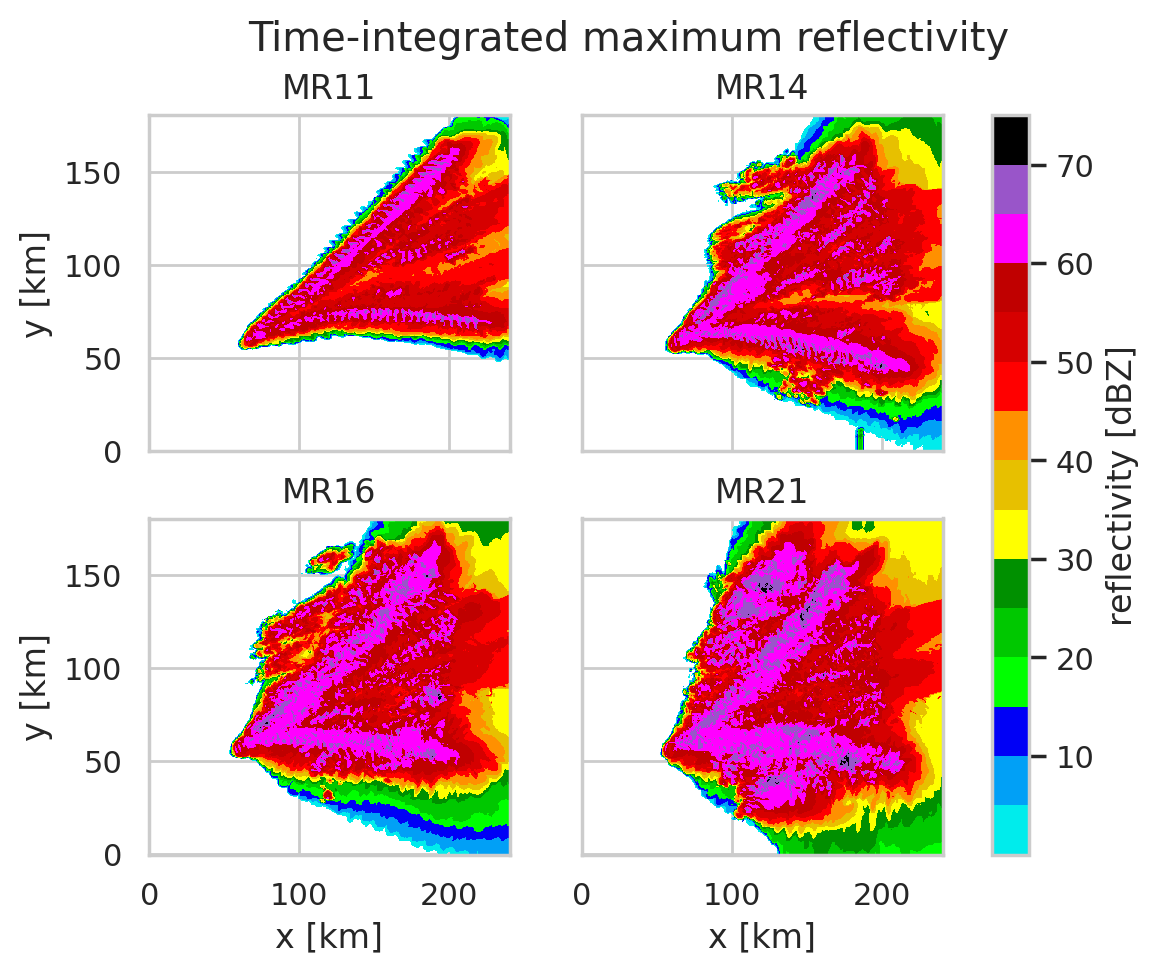

In [16]:
# visualisation
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()
cmap = ctables.registry.get_colortable('NWSReflectivity')
cmap.set_under(alpha=0)
norm = colors.Normalize(vmin=.01, vmax=75)

for i, mr in enumerate(sims):
    # dimensions: 240x180x20 km, 480x360x80 grid
    cm = axs[i].pcolormesh(np.linspace(0,240,480), np.linspace(0,180,360), maxdbz[mr],
                           cmap=cmap, norm=norm)
    axs[i].set_title(mr.upper())
    if i in (2, 3):
        axs[i].set_xlabel('x [km]')
    if i in (0, 2):
        axs[i].set_ylabel('y [km]')

fig.colorbar(cm, ax=axs, label="reflectivity [dBZ]")
fig.suptitle("Time-integrated maximum reflectivity")
fig.savefig("../figs/cref.png", dpi=300, bbox_inches="tight")

## Vertical velocity

Analyse speed & extent of updraft region.

- **maximum vertical velocity**: time series of maximum vertical velocity within entire domain
- **20 m/s updraft region**: mean (horizontal) area of $w \ge$ 20 m/s updraft

both sampled between 4 and 8 km AGL (optimal hail growth region)

In [17]:
# import vertical velocity [m/s]

w = {}
maxw = {}
for mr in sims:
    # select optimal hail growth region from 4 to 8 km AGL
    w[mr] = xr.open_dataset(f"/daten/model-course/WS2023/rw0064fu/cm1/{mr.upper()}/cm1out.nc")['w'].sel(zf=slice(4,8))
    # compute max vertical velocity
    maxw[mr] = w[mr].max(dim=['xh', 'yh', 'zf'])

In [18]:
areaw = {}
for mr in sims:
    # compute 20 m/s updraft area
    areaw[mr] = w[mr].where(w[mr] >= 20).count(dim=['xh', 'yh']).mean(dim='zf')*.5*.5 # convert to km^2 (dx, dy = 500m)

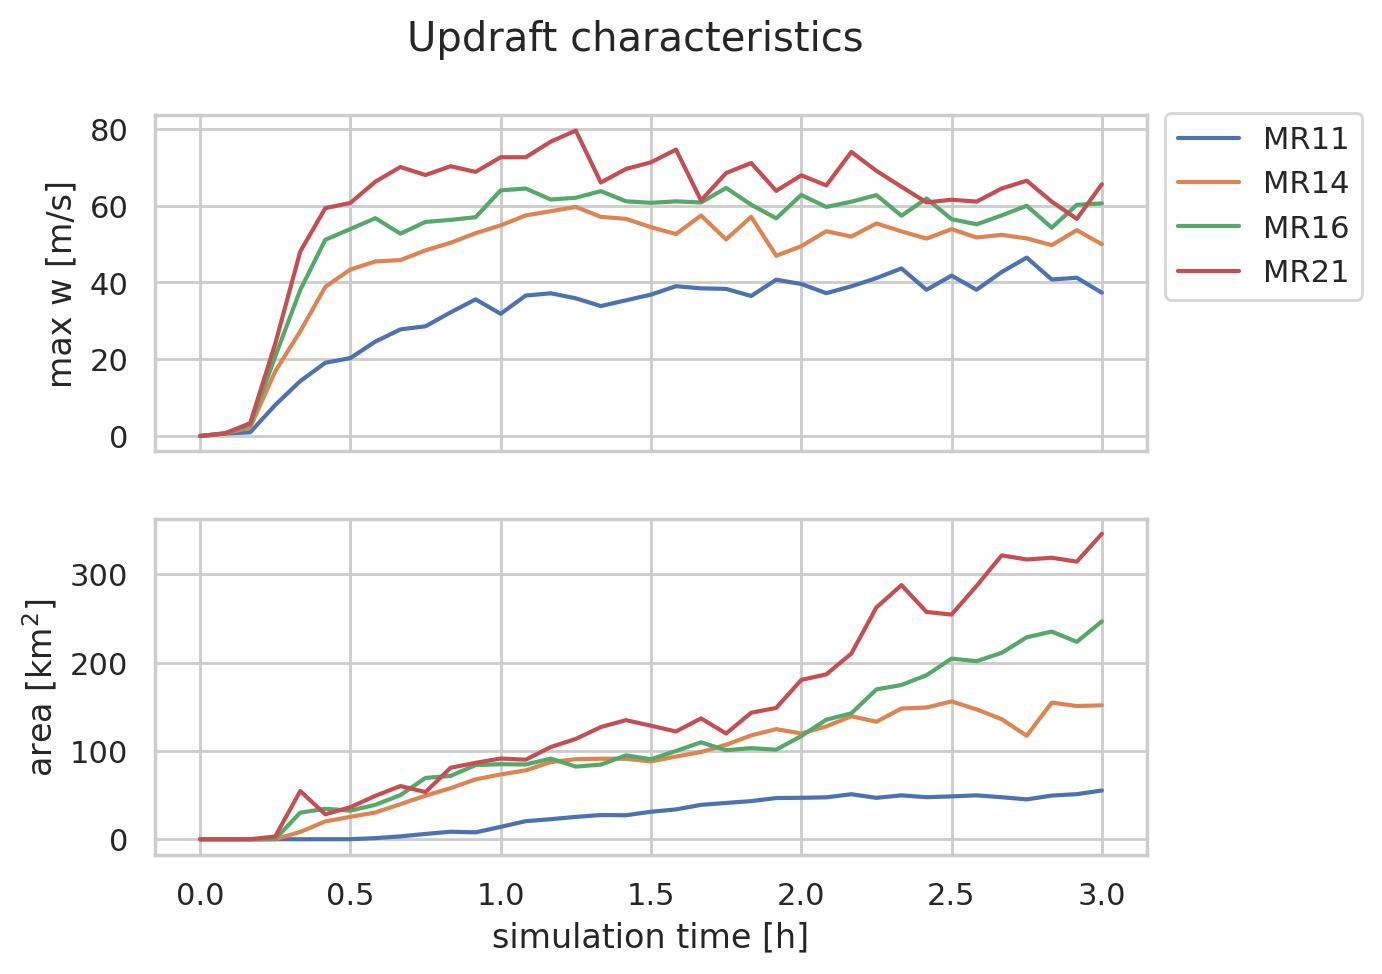

In [19]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs = axs.flatten()

for mr in sims:
    #maxw[mr].plot(ax=axs[0], label=mr.upper())
    axs[0].plot(maxw[mr]['time'].dt.seconds/60/60, # convert from seconds (by accessing timedelta) to hours
                maxw[mr])
    axs[1].plot(areaw[mr]['time'].dt.seconds/60/60,
                areaw[mr],
                label=mr.upper())

axs[0].set_ylabel('max w [m/s]')
axs[1].set_ylabel(r'area [km$^2$]')
axs[1].set_xlabel('simulation time [h]')
fig.suptitle('Updraft characteristics')
fig.legend(bbox_to_anchor=(1.08, 0.898))
fig.savefig("../figs/updraft.png", dpi=300, bbox_inches="tight")

## Hail mixing ratio

In [20]:
# import hail mixing ratio [kg/kg]

qh = {}
lowqh = {}
for mr in sims:
    qh[mr] = xr.open_dataset(f"/daten/model-course/WS2023/rw0064fu/cm1/{mr.upper()}/cm1out.nc")['qg'] * 1e3 # convert from [kg/kg] to [g/kg]
    # compute mean hail mixing ratio on lowest model level
    lowqh[mr] = qh[mr].sel(zh=0.125).mean(dim=['xh', 'yh'])

In [21]:
# convert dict values to lists
cape = []
lowqhmean = []
for mr in sims:
    cape.append(sbcape[mr].magnitude)
    lowqhmean.append(lowqh[mr].mean(dim='time').item())

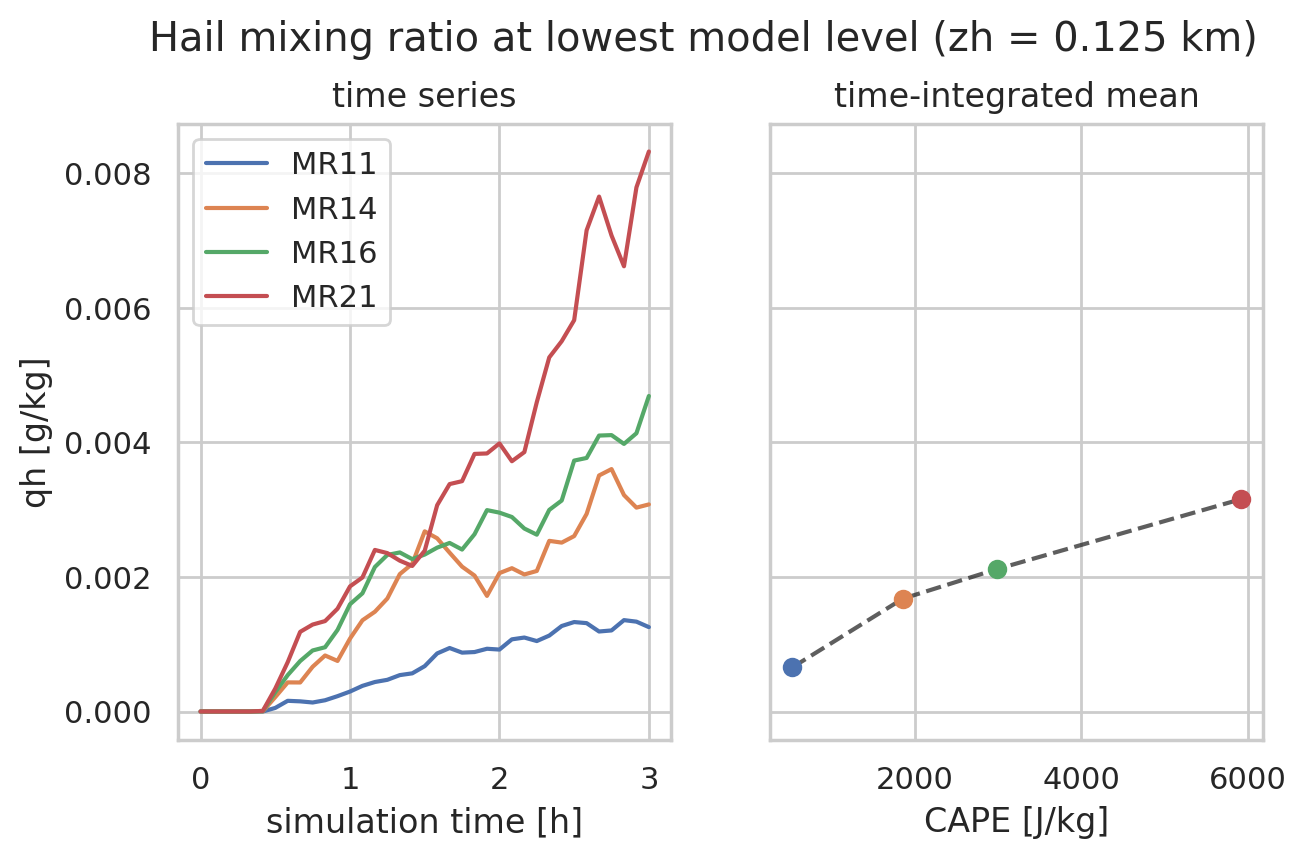

In [22]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7,4))
axs = axs.flatten()

for i, mr in enumerate(sims):
    axs[0].plot(lowqh[mr]['time'].dt.seconds/60/60, # convert from seconds (by accessing timedelta) to hours
                lowqh[mr],
                label=mr.upper())
    axs[1].scatter(cape[i], lowqhmean[i], zorder=3)
# connect scatter dots
axs[1].plot(cape, lowqhmean, c='k', alpha=.7, ls='--')
# beautification
axs[0].legend()
axs[0].set_ylabel('qh [g/kg]')
axs[0].set_xlabel('simulation time [h]')
axs[0].set_title('time series')
axs[1].set_title('time-integrated mean')
axs[1].set_xlabel('CAPE [J/kg]')
fig.suptitle('Hail mixing ratio at lowest model level (zh = 0.125 km)', y=1.01)
fig.savefig("../figs/hail.png", dpi=300, bbox_inches="tight")